# Softsensor, Predict of butane concentration in a Chemical process

## **[Purpose of this project]**
#### -Naphtha contains a mixture of various componets, which are removed and separated in a distillation column to obtain the refined product. Since this facility is operated continuously, contorl of the system while periodically analyzing samples will cause delays in operation, so it is operated while predicting the results in advance. In this case, the butane concentration at the bottom of the column is predicted from the data around the Debutanizer Column (x1-x7)

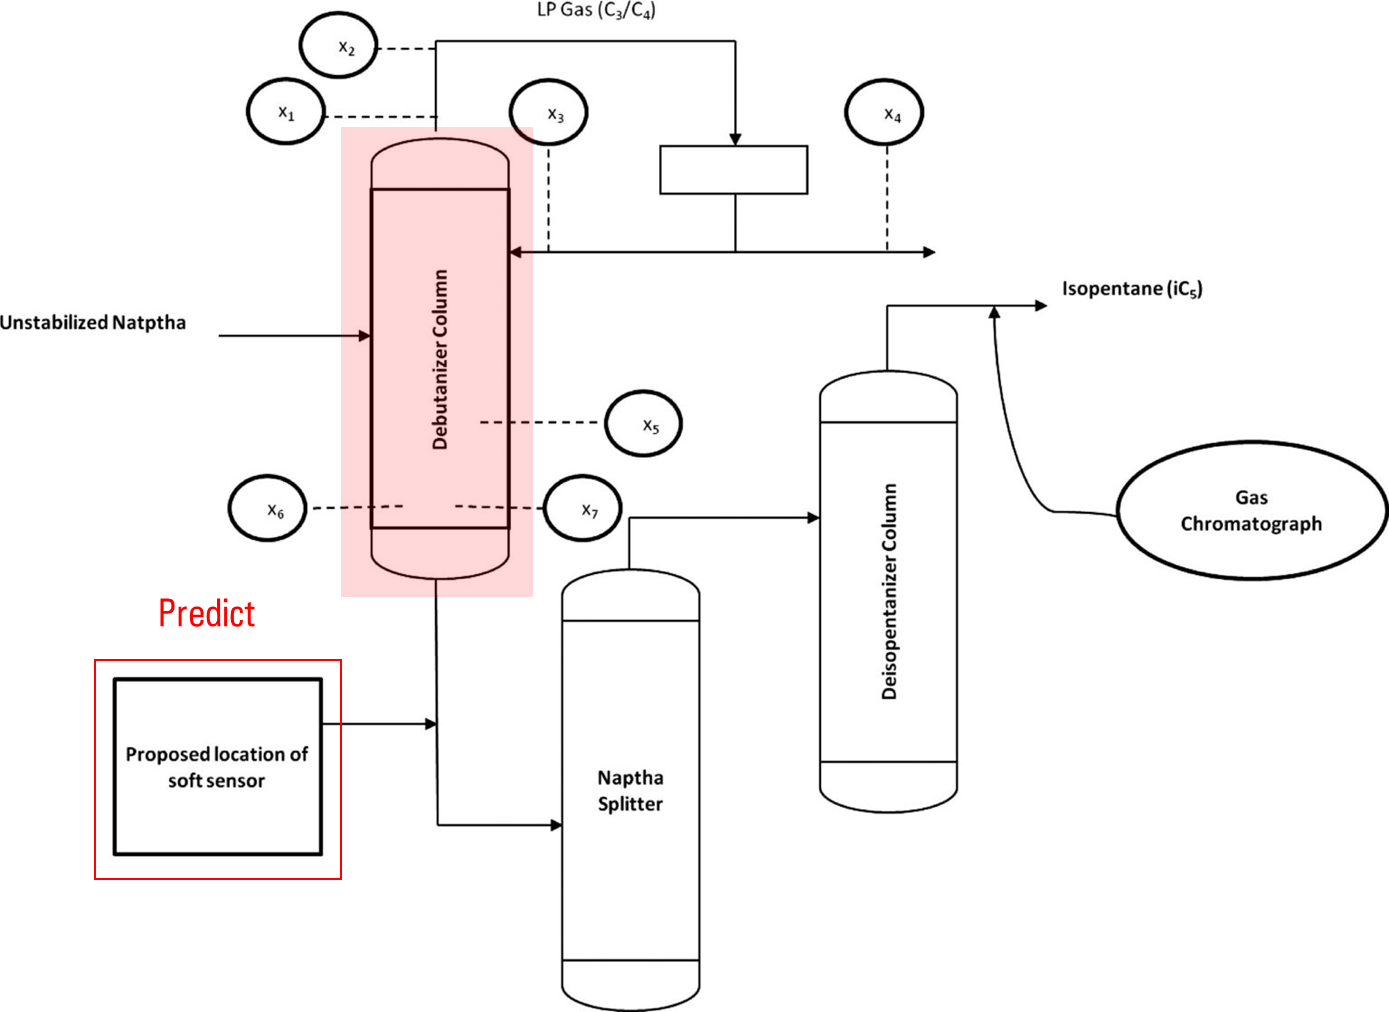

In [8]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## *-Predictor and Objective variables-*

In [46]:
pd.set_option('display.max_colwidth', None)
df_variables = pd.DataFrame({'VariableName':['x1','x2','x3','x4','x5','x6','x7','y'], 'Detail':['Top Temp.','Top Pressure','Refulx flow', 'Flow to next process', '6th tray Temp.','Bottom Temp.1','Bottom Temp.2','Butane content in the debutanizer column bottom']})
display(df_variables)

,VariableName,Detail
0,x1,Top Temp.
1,x2,Top Pressure
2,x3,Refulx flow
3,x4,Flow to next process
4,x5,6th tray Temp.
5,x6,Bottom Temp.1
6,x7,Bottom Temp.2
7,y,Butane content in the debutanizer column bottom


## 1. EDA
- All this data is time series data, assign time to the index
- Delete data for periods where y is nan
- Takes 5 min to analyse y (date_index - 5 min)

In [29]:
def load_data():
    df = pd.read_csv('debutanizer_data.csv', header=0)
    # Assume practical data and assign time to index since it is time series data
    start_datetime = '2024-01-01 00:00:00'
    n = len(df)
    date_index = pd.date_range(start=start_datetime, periods=n, freq='min') 
    df.index = date_index
    # Consider the measurement time of the objective variable (5minutes)
    df['y'] = df['y'].shift(5)
    # Delete NaN
    df = df.dropna()
    return df

In [31]:
df = load_data()
df.describe()

,x1,x2,x3,x4,x5,x6,x7,y
count,2389.000000,2389.000000,2389.000000,2389.000000,2389.000000,2389.000000,2389.000000,2389.000000
mean,0.283927,0.667873,0.598012,0.435664,0.657863,0.620340,0.588971,0.267994
std,0.103248,0.057746,0.198535,0.138241,0.127091,0.165051,0.173178,0.159044
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.223966,0.653819,0.500345,0.363335,0.608484,0.480616,0.444644,0.169199
50%,0.263816,0.671993,0.623921,0.395552,0.694471,0.638792,0.599711,0.247208
75%,0.325687,0.690945,0.741118,0.517321,0.729744,0.754681,0.740169,0.318080
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### *These data have standaraized alreday*

In [33]:
# Split into predicotr X and objective variale y
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## *-Data Visualizing-*

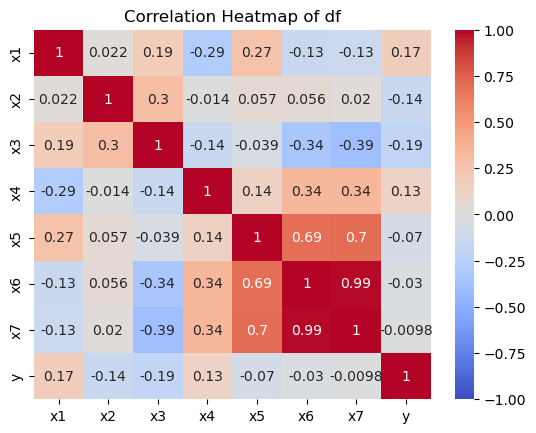

In [36]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of df")
plt.show()

#### *-From cheking the pairplot, It can be seen that there are no predictors that are highly correlated with y. This could be due to the fact that when each value changed, there was a delay before it was reflected in y (as it is time series data). Check the correlation between y and the data from 0-30 minutes before each predictor and adjust to the lag time with the highest correlation.*

## *-Creating a dataset of lag features-*

In [46]:
# Create DataFrame
correlations = pd.DataFrame()

# Create features from lag 0 to 30 and calculate correlation with y
for col in X.columns:  # For all columns except y
    for lag in range(31):  # Lag 0 to 30
        X_lagged = X[col].shift(lag)
        corr = X_lagged.corr(y)
        correlations.loc[lag, col] = corr

# Extract the lag with the largest absolute value of R^2 for each column
best_lags = correlations.abs().idxmax()

# Create dataset containing only the most highly correlated lag features
df_lag = pd.DataFrame()
for col, lag in best_lags.items():
    df_lag[f'{col}_lag_{lag}'] = X[col].shift(lag)

# Delete NaN
df_lag['y'] = y
df_lag.dropna(inplace=True)

# Show result
df_lag.describe()

,x1_lag_21,x2_lag_11,x3_lag_13,x4_lag_8,x5_lag_20,x6_lag_22,x7_lag_22,y
count,2367.000000,2367.000000,2367.000000,2367.000000,2367.000000,2367.000000,2367.000000,2367.000000
mean,0.283008,0.667992,0.596828,0.435359,0.657594,0.619559,0.588608,0.268915
std,0.102816,0.057977,0.199004,0.138594,0.127416,0.165382,0.173679,0.159488
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.223509,0.654046,0.499749,0.363394,0.607706,0.479204,0.442822,0.171294
50%,0.263363,0.672217,0.622729,0.395450,0.694334,0.636928,0.599527,0.248449
75%,0.324709,0.691116,0.737725,0.516047,0.729744,0.754796,0.740789,0.320807
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
# Split into predicotr X and objective variale y
X_lag = df_lag.iloc[:, :-1]
y_lag = df_lag.iloc[:, -1]

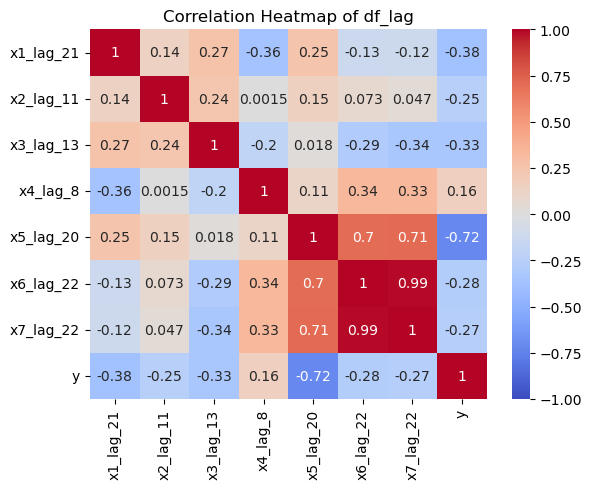

In [50]:
corr = df_lag.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of df_lag")
plt.show()

#### *-We can see that there is more correlation between the predictor and y than at the beginning, Next we try to constract model*

## 2. Model building

- Split the data with 60% of the data as training data and the rest as test data
- As it is time series data, no shuffling is done (as data order is important)
- Compare the number of predictors with R2 and select the optimal number

## *-Define function-*
### Compare three models

### 1. RandomForest Regression

In [74]:
def perform_rf_regression_with_oob_test_plot(X, y, number_of_trees=300, test_size=0.4, shuffle=False, fixed_max_depth=3):
    """
    Perform Random Forest (RF) regression by tuning max_features,
    comparing OOB score and test score, and visualizing them.

    Parameters:
    X : pd.DataFrame
        Explanatory variable dataset
    y : pd.Series
        Target variable dataset
    number_of_trees : int
        Number of trees to use (default is 300)
    test_size : float
        Proportion of the data to use as test set (default 0.4)
    shuffle : bool
        Whether to shuffle the data when splitting (default False)
    fixed_max_depth : int
        Fixed tree depth to use for all trees (default 3)

    Returns:
    best_params : dict
        Best parameters (optimal max_features_rate)
    rf_final : RandomForestRegressor
        Final trained Random Forest model
    """

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=shuffle, random_state=0
    )

    # Tuning target: rate of max_features
    x_variables_rates = np.arange(0.1, 1.1, 0.1)

    # List to store results
    results = []

    for x_rate in x_variables_rates:
        rf = RandomForestRegressor(
            n_estimators=number_of_trees,
            max_features=int(np.ceil(X_train.shape[1] * x_rate)),
            max_depth=fixed_max_depth,
            oob_score=True,
            random_state=0,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)

        # OOB score
        oob_r2 = rf.oob_score_

        # R2 score on test data
        y_test_pred = rf.predict(X_test)
        r2_test = metrics.r2_score(y_test, y_test_pred)

        results.append((x_rate, oob_r2, r2_test))

    # Separate results for plotting
    x_rates = [r[0] for r in results]
    oob_scores = [r[1] for r in results]
    test_scores = [r[2] for r in results]

    plt.figure(figsize=(10,6))
    plt.plot(x_rates, oob_scores, marker='o', linestyle='-', label='OOB R2 Score')
    plt.plot(x_rates, test_scores, marker='x', linestyle='--', label='Test R2 Score')
    plt.xlabel('max_features Rate')
    plt.ylabel('R2 Score')
    plt.title('Random Forest: OOB vs Test R2 (fixed max_depth)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Find the best max_features_rate (based on maximizing Test R2)
    best_idx = np.argmax(test_scores)
    best_x_rate = x_rates[best_idx]

    print(f"Best max_features rate (based on Test R2): {best_x_rate}")
    print(f"Best Test R2: {test_scores[best_idx]:.3f}")
    print(f"Corresponding OOB R2: {oob_scores[best_idx]:.3f}")

    # Create final model using the best parameters
    rf_final = RandomForestRegressor(
        n_estimators=number_of_trees,
        max_features=int(np.ceil(X_train.shape[1] * best_x_rate)),
        max_depth=fixed_max_depth,
        oob_score=True,
        random_state=0,
        n_jobs=-1
    )
    rf_final.fit(X_train, y_train)

    # Final performance evaluation (assumes existence of evaluate_model function)
    evaluate_model(X_train, y_train, X_test, y_test, model=rf_final)

    best_params = {
        'max_features_rate': best_x_rate,
        'fixed_max_depth': fixed_max_depth
    }

    return best_params, rf_final

### 2. Adaboost

In [175]:
def perform_adaboost_regression(X, y, number_of_estimators=300, test_size=0.4, shuffle=False):
    """
    Build an AdaBoost regression model, train it directly without cross-validation,
    and evaluate its performance on both training and testing datasets.

    Parameters:
    X : pd.DataFrame
        Feature dataset (explanatory variables)
    y : pd.Series
        Target variable dataset
    number_of_estimators : int, optional
        Number of weak learners (base estimators, default decision trees) (default is 300)
    test_size : float, optional
        Proportion of the dataset to allocate to testing (default is 0.4)
    shuffle : bool, optional
        Whether to shuffle the data during splitting (default is False, assuming time series data)

    Returns:
    model : AdaBoostRegressor
        Trained AdaBoost regression model
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=0)

    # Create the AdaBoost model
    ada_model = AdaBoostRegressor(
        base_estimator=RandomForestRegressor(max_depth=3, max_features=0.5),
        n_estimators=number_of_estimators,
        learning_rate=0.01,
        random_state=0
    )

    # Train the model
    ada_model.fit(X_train, y_train)

    # Evaluate the model
    evaluate_model(X_train, y_train, X_test, y_test, model=ada_model)

    return ada_model

### 3.Multiple linear regression

In [145]:
def perform_linear_regression_with_plot(X, y, test_size=0.4, shuffle=False):
    """
    Build a multiple linear regression model,
    compare its performance on training and testing data,
    and generate time series plots and actual vs predicted scatter plots.

    Parameters:
    X : pd.DataFrame
        Feature dataset (explanatory variables)
    y : pd.Series
        Target variable dataset
    test_size : float
        Proportion of the dataset used for testing (default is 0.4)
    shuffle : bool
        Whether to shuffle the data before splitting (default is False)

    Returns:
    model : LinearRegression
        Trained linear regression model
    """

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=shuffle, random_state=0
    )

    # Create and train the model
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Final performance evaluation (assumes existence of evaluate_model function)
    evaluate_model(X_train, y_train, X_test, y_test, model=Ir)

    return lr

## -Performance evaluation on training and test data-

In [148]:
def evaluate_performance(X, y, model, save_to_csv=False, filename='performance.csv'):
    """
    Evaluate the performance of a trained model and plot the results.
    Optionally, save the prediction results to a CSV file.

    Parameters:
    X : pd.DataFrame
        Feature dataset (explanatory variables)
    y : pd.Series
        Target values
    model : sklearn model
        Trained model to evaluate
    save_to_csv : bool, optional
        Whether to save the results to a CSV file (default is False)
    filename : str, optional
        Name of the output CSV file (default is 'performance.csv')

    Returns:
    r2 : float
        Coefficient of determination (R² score)
    rmse : float
        Root Mean Squared Error
    mae : float
        Mean Absolute Error
    """
    # Predict y values using the model
    y_pred = model.predict(X)

    # Calculate performance metrics
    r2 = metrics.r2_score(y, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    mae = metrics.mean_absolute_error(y, y_pred)
    print(f"R^2: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")
    
    # Create scatter plot: Actual vs Predicted
    plt.figure(figsize=(6, 6))
    plt.scatter(y, y_pred, color='blue')
    y_max = max(y.max(), y_pred.max())
    y_min = min(y.min(), y_pred.min()) 
    
    # Draw a diagonal reference line with ±5% margin
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
             [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-') 
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)) 
    plt.xlabel('Actual y')
    plt.ylabel('Predicted y')
    # Display R2, RMSE, MAE in a text box at the bottom right
    plt.text(0.98, 0.02, f'R^2: {r2:.3f}\nRMSE: {rmse:.3f}\nMAE: {mae:.3f}', transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='bottom', horizontalalignment='right', 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.5))
    plt.title(filename[:-4])
    plt.grid(False)
    plt.axis('equal')
    plt.show()

    # Create time series plot: Actual vs Predicted
    plt.figure(figsize=(10, 5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Format x-axis as datetime
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=5))  # Major ticks every 5 hours
    plt.plot(y.index, y, label='Actual y', color='blue', marker='', linestyle='-')
    plt.plot(y.index, y_pred, label='Predicted y', color='red', marker='', linestyle='-')
    # Uncomment below to automatically rotate date labels
    # plt.gcf().autofmt_xdate()
    plt.ylabel('y')
    plt.title(filename[:-4])
    plt.legend()
    plt.show()
    
    # Save results to CSV file if requested
    if save_to_csv:
        results_df = pd.DataFrame({
            'Actual': y,
            'Predicted': y_pred.flatten(),
            'Error': y - y_pred.flatten()
        })
        results_df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")
    
    return r2, rmse, mae

In [150]:
def evaluate_model(X_train, y_train, X_test, y_test, model, save_csv=False, train_filename='train_performance.csv', test_filename='test_performance.csv'):
    """
    Evaluate the performance of a trained model on both training and testing datasets.

    Parameters:
    X_train : pd.DataFrame
        Feature variables of the training data
    y_train : pd.Series
        Target variable of the training data
    X_test : pd.DataFrame
        Feature variables of the test data
    y_test : pd.Series
        Target variable of the test data
    model : sklearn model
        Trained model to be evaluated
    save_csv : bool, optional
        Whether to save the evaluation results to CSV files (default is False)
    train_filename : str, optional
        Filename for saving the training data prediction results (default is 'train_performance.csv')
    test_filename : str, optional
        Filename for saving the test data prediction results (default is 'test_performance.csv')
    """
    print("Evaluating Training Data")
    evaluate_performance(X_train, y_train, model, save_to_csv=save_csv, filename=train_filename)
    print("Evaluating Test Data")
    evaluate_performance(X_test, y_test, model, save_to_csv=save_csv, filename=test_filename)

In [162]:
def evaluate_models(X, y, test_size=0.4, shuffle=False, number_of_trees=300):
    """
    Create and evaluate Random Forest, AdaBoost, and Multiple Linear Regression models,
    summarizing R2, RMSE, and MAE scores for both training and testing data in a DataFrame.

    Parameters:
    X : pd.DataFrame
        Feature dataset (explanatory variables)
    y : pd.Series
        Target variable
    test_size : float
        Proportion of the data to be used as test set
    shuffle : bool
        Whether to shuffle the data when splitting
    number_of_trees : int
        Number of trees used in Random Forest and AdaBoost

    Returns:
    pd.DataFrame
        Performance comparison table for each model
    """

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.tree import DecisionTreeRegressor

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=0)

    # Define models to be evaluated
    models = {
        'RandomForest': RandomForestRegressor(
            n_estimators=number_of_trees, max_depth=3, max_features='sqrt', random_state=0, n_jobs=-1, oob_score=False),
        'AdaBoost': AdaBoostRegressor(
            base_estimator=DecisionTreeRegressor(max_depth=3, max_features=0.5,random_state=0),
            n_estimators=number_of_trees,
            learning_rate=0.01,
            random_state=0),
        'LinearRegression': LinearRegression()
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate scores for training data
        r2_train = r2_score(y_train, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        mae_train = mean_absolute_error(y_train, y_train_pred)

        # Calculate scores for testing data
        r2_test = r2_score(y_test, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        mae_test = mean_absolute_error(y_test, y_test_pred)

        # Store the results
        results.append({'Model': name, 'DataType': 'Train', 'R2': r2_train, 'RMSE': rmse_train, 'MAE': mae_train})
        results.append({'Model': name, 'DataType': 'Test', 'R2': r2_test, 'RMSE': rmse_test, 'MAE': mae_test})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

## 3. Result evaluation

### RandomForest

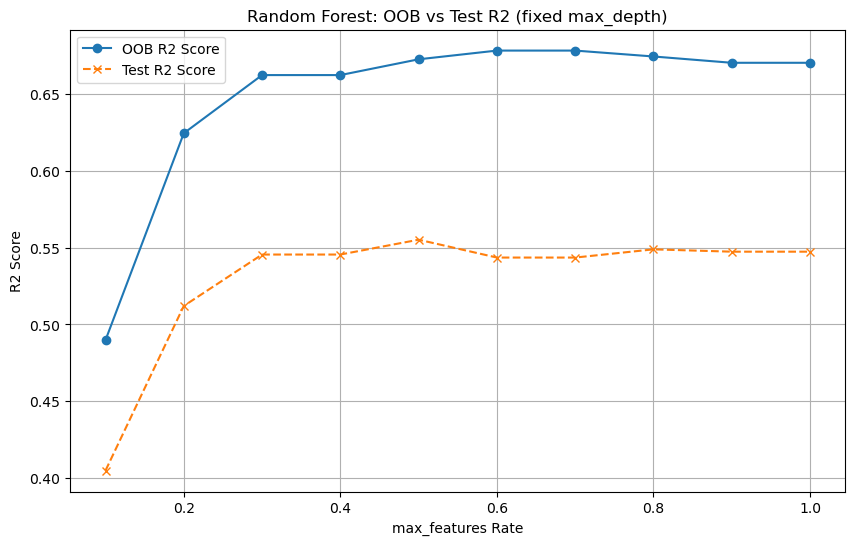

Best max_features rate (based on Test R2): 0.5
Best Test R2: 0.555
Corresponding OOB R2: 0.673
Evaluating Training Data
R^2: 0.710, RMSE: 0.076, MAE: 0.054


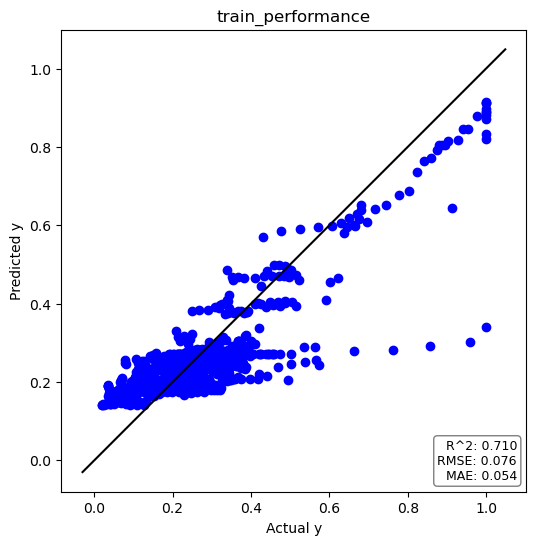

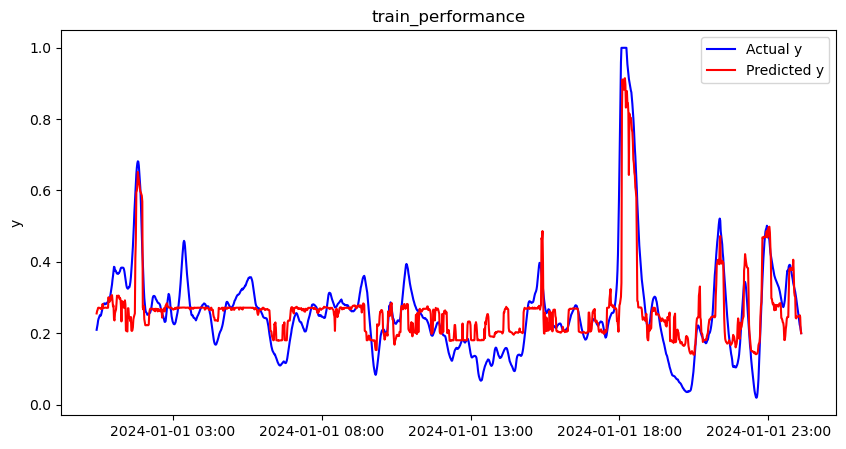

Evaluating Test Data
R^2: 0.555, RMSE: 0.122, MAE: 0.090


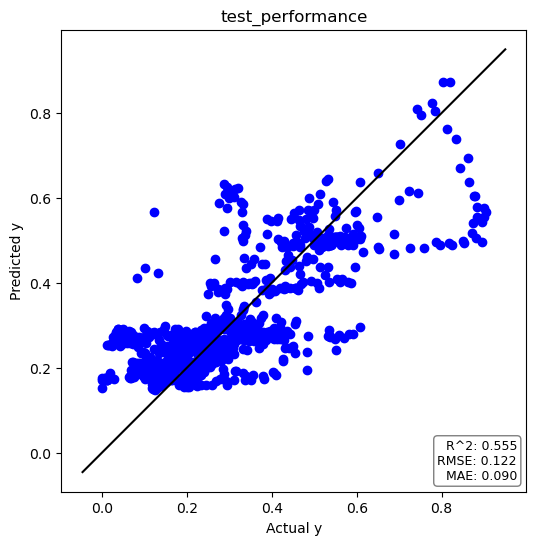

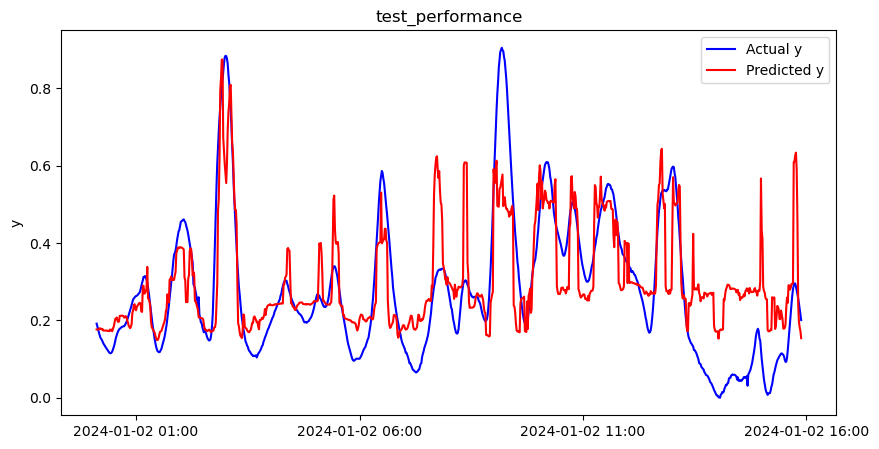

In [169]:
optimal_x_variables_rate, rf_final = perform_rf_regression_with_oob_test_plot(X_lag, y_lag)

### Adaboost

C:\Users\d1070\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Evaluating Training Data
R^2: 0.739, RMSE: 0.072, MAE: 0.055


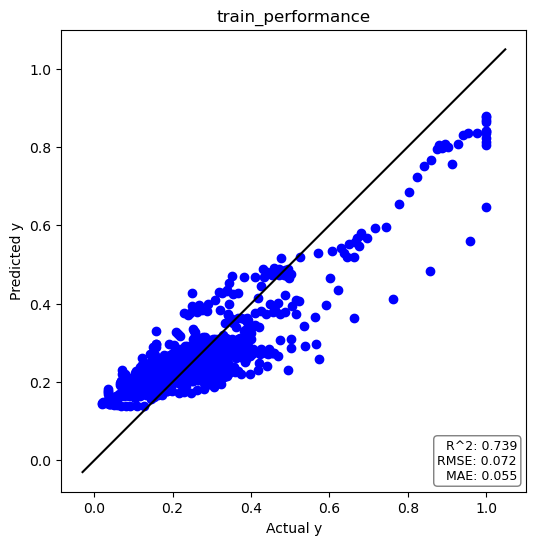

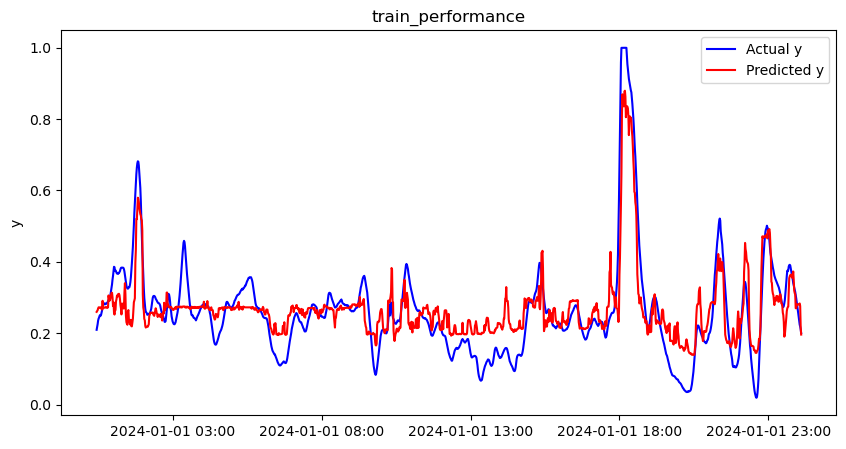

Evaluating Test Data
R^2: 0.519, RMSE: 0.127, MAE: 0.097


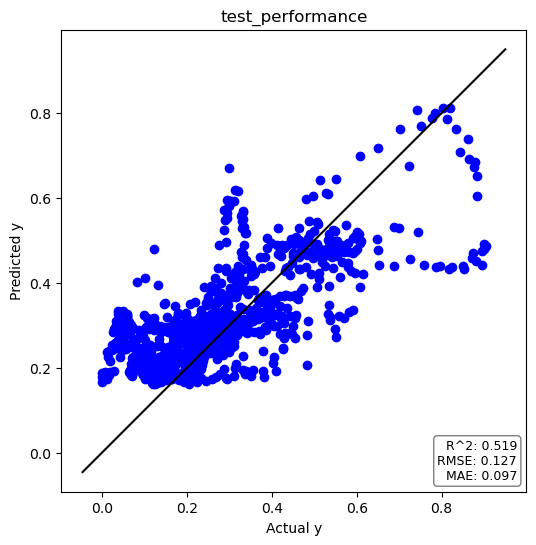

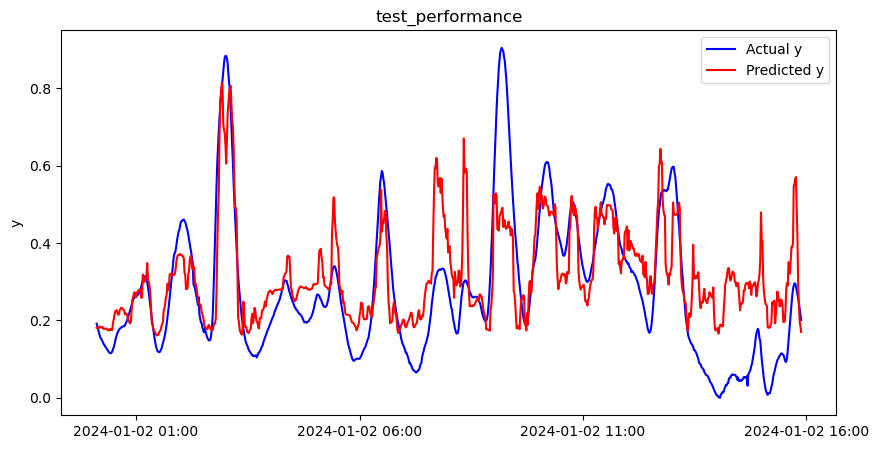

In [177]:
ada_model = perform_adaboost_regression(X_lag, y_lag)

### Multi linear Regression

Evaluating Training Data
R^2: 0.627, RMSE: 0.086, MAE: 0.062


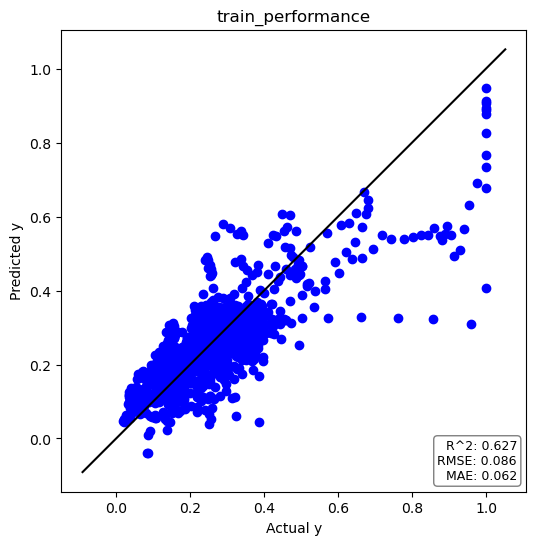

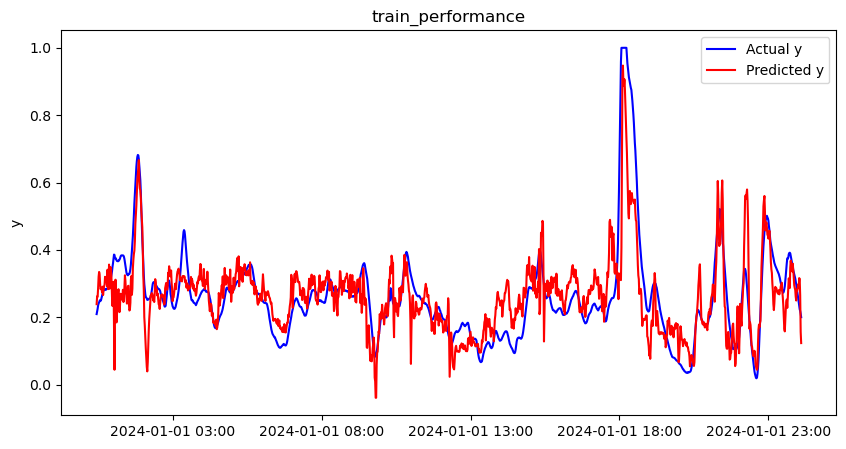

Evaluating Test Data
R^2: 0.521, RMSE: 0.127, MAE: 0.091


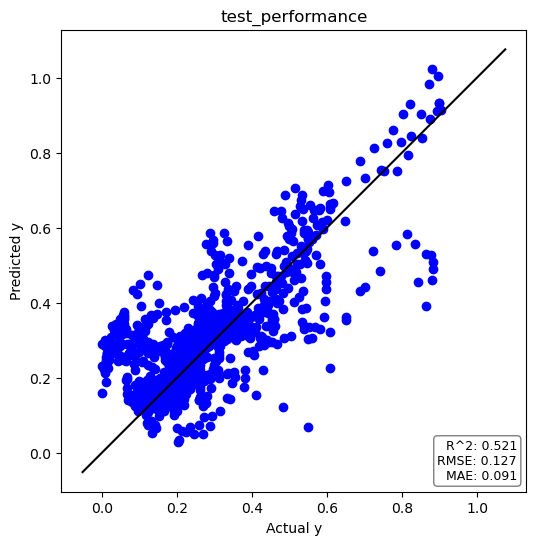

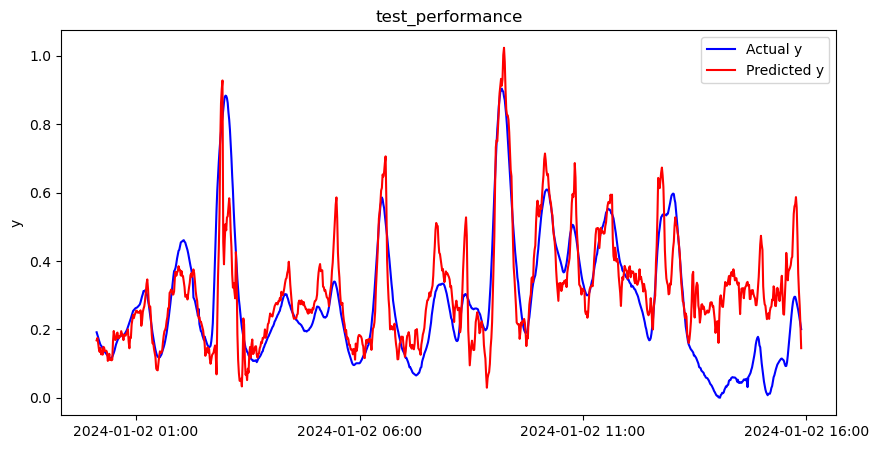

In [173]:
Ir = perform_linear_regression_with_plot(X_lag, y_lag)

In [164]:
evaluate_models(X_lag, y_lag)

C:\Users\d1070\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


,Model,DataType,R2,RMSE,MAE
0,RandomForest,Train,0.665026,0.081788,0.058441
1,RandomForest,Test,0.511937,0.127709,0.095932
2,AdaBoost,Train,0.739996,0.072057,0.053965
3,AdaBoost,Test,0.517422,0.126989,0.094247
4,LinearRegression,Train,0.626964,0.086310,0.061679
5,LinearRegression,Test,0.520585,0.126572,0.091103


## 4. Conclusion

### *-Compared the performance of the 3 models: R^2, RMSE and MAE show that the performance of them are almost the same.However, when comparing the actual time series data to predictions, Multiple Linear regression model is able to reproduce even smaller fluctuaions.The others are not able to reproduce small fluctuations when y<0.2.*

### *-Therefore, for the purpose of continuous prediction, the multiple Linear Regression model is the best.*